In [22]:
import os
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from pandas import DataFrame
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [5]:
caminho_arquivo = 'dados_prod_update.xlsx'

# Usando o método read_excel para ler o arquivo .xlsx em um DataFrame
df = DataFrame(pd.read_excel(caminho_arquivo, header=0))

#Vamos utilizar o valor ajustado da pressão média como saida para o modelo supervisionado

y = df['P_ajustada'].values

#Visualizando o dataframe

df.head()

,Data,Dias,P_ajustada,P_medida,P1 Qo (m³/d),P1 Qg (mil m³/d),P1 Qw (m³/d),P2 Qo (m³/d),P2 Qg (mil m³/d),P2 Qw (m³/d),...,P5 Qw,P5 Np,P5 Gp,P5 Wp,P6 Qo,P6 Qg,P6 Qw,P6 Np,P6 Gp,P6 Wp
0,2021-08-03,0,628.91328,628.91328,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-08-04,1,628.91028,628.91028,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-08-05,2,628.90728,628.90728,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-08-06,3,628.90528,628.90528,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-08-07,4,628.90228,628.90228,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#Definindo a matriz dos dados de entrada

matriz_entrada = list(df.columns)[4:]
matriz_correlacao = ['P_ajustada']

for i in range(len(matriz_entrada)):
    matriz_correlacao.append(matriz_entrada[i])

#Aplicando a padronização de escala das variáveis    
    
X1 = df[matriz_entrada].values
scaler = MinMaxScaler(feature_range=(0,1))
X1s = scaler.fit_transform(X1)




(43, 43)


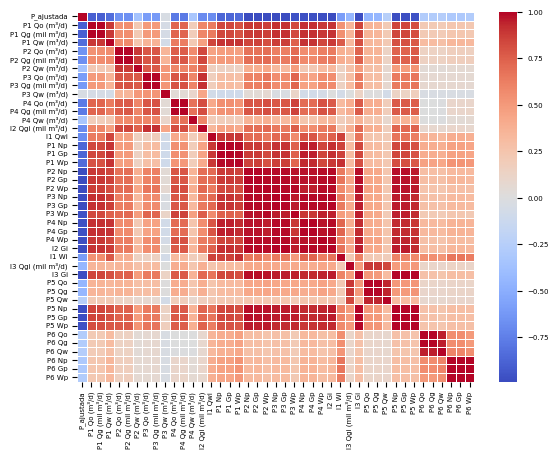

<Figure size 2000x2000 with 0 Axes>

In [7]:
#Matriz de correlação cruzada para análise exploratória dos dados

matriz_corr = df[matriz_correlacao].corr().round(2)
print(matriz_corr.shape)
sns.heatmap(matriz_corr, annot=False, cmap='coolwarm', linewidths=0.5, xticklabels= True,  yticklabels = True)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)

cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=5)
plt.figure(figsize=(20, 20))
plt.show()

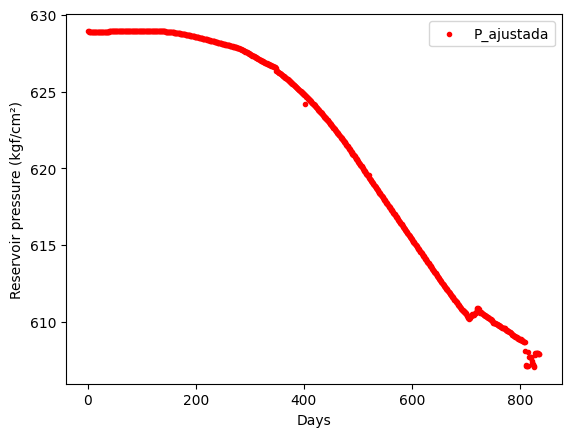

In [8]:
dias = range(1,837)

plt.scatter(dias, y, label = 'P_ajustada', color = 'r', marker = '.')
plt.legend()
plt.ylabel('Reservoir pressure (kgf/cm²)')
plt.xlabel('Days')
plt.show()

In [9]:
pca = PCA()
pca.fit(X1s)


PCA()

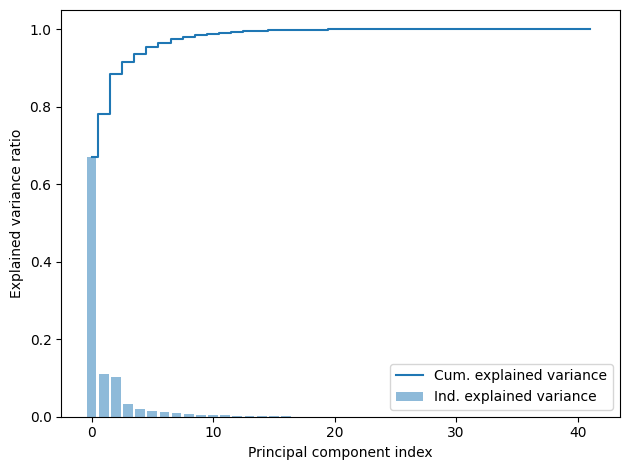

In [10]:
#Verificando a variância explicada das componentes da matriz de entrada

exp_var_pca = pca.explained_variance_ratio_
cum_sum_variance = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center',label='Ind. explained variance')
plt.step(range(0,len(cum_sum_variance)), cum_sum_variance, where='mid', label='Cum. explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [11]:
#Obtendo os componentes principais

X1_reduced=pca.fit_transform(X1s)
componentes=len(cum_sum_variance[cum_sum_variance<0.99])
#componentes = 5
X2=X1_reduced[:,0:componentes]
X2.shape

(836, 11)

In [12]:
#Importando os módulos para aplicação dos modelos de ML

from scipy import stats
from scipy.stats import mode
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, RepeatedKFold, 
RandomizedSearchCV)
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
#Define models

models = []
models.append(("LRG", Ridge()))
models.append(("SVR", SVR()))
models.append(("KNN", KNeighborsRegressor()))

#Define hyperparams to be tested

param_grids = []

param_grids.append(
    [
        {
            "LRG__alpha": stats.loguniform(1e-1, 1e1),
            "LRG__solver" : ['auto']
        }
    ]
)

param_grids.append(
    [
        {
            "SVR__C" : stats.loguniform(1e-1, 1e1),
            "SVR__kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
            "SVR__degree" : stats.randint(2, 5),
            "SVR__gamma" : stats.loguniform(1e-4, 1e0),
        }
    ]
)

param_grids.append(
    [
        {
            "KNN__n_neighbors" : stats.randint(2, 5),
            "KNN__weights" : ['uniform', 'distance'],
            "KNN__algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
        }
    ]
)

In [14]:
#Separação dos datasets de treino e teste e início do loop de busca dos hiperparametros

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.4, random_state=42)

rkf = RepeatedKFold(n_splits = 5, n_repeats = 50, random_state = 0)

best_params = []
yh_test_loop = []
y_test_loop = []

for k in range(len(models)):
        
    clf = Pipeline([(models[k])])
    
    param_grid = param_grids[k]
    
    random_search = RandomizedSearchCV(clf, verbose = True, scoring = 'neg_mean_squared_error', param_distributions = param_grid, 
                                       n_iter = 100, n_jobs = -1, cv = rkf, random_state = 0)

    random_search.fit(X_train, y_train)
    
    yh_test = random_search.predict(X_test)
    
    yh_test_loop.append(yh_test)
    y_test_loop.append(y_test)
    
    best_params.append(random_search.best_params_)

Fitting 250 folds for each of 100 candidates, totalling 25000 fits
Fitting 250 folds for each of 100 candidates, totalling 25000 fits
Fitting 250 folds for each of 100 candidates, totalling 25000 fits


In [15]:
#Resultado das iterações e os melhores hiperparâmetros encontrados com os respectivos erros médios quadrados

print(best_params)

for i in range(len(models)):
    print(models[i][0])
    print(mean_squared_error(y_test_loop[i], yh_test_loop[i]))

[{'LRG__alpha': 0.1343677338411073, 'LRG__solver': 'auto'}, {'SVR__C': 8.527710354725972, 'SVR__degree': 2, 'SVR__gamma': 0.07961907345193564, 'SVR__kernel': 'rbf'}, {'KNN__algorithm': 'kd_tree', 'KNN__n_neighbors': 4, 'KNN__weights': 'distance'}]
LRG
0.11590153960938532
SVR
0.03254014350400007
KNN
0.10101021420630077


In [17]:
#Realizando uma avaliação dos modelos segundo o R²

from sklearn.metrics import r2_score

Fitting 250 folds for each of 100 candidates, totalling 25000 fits


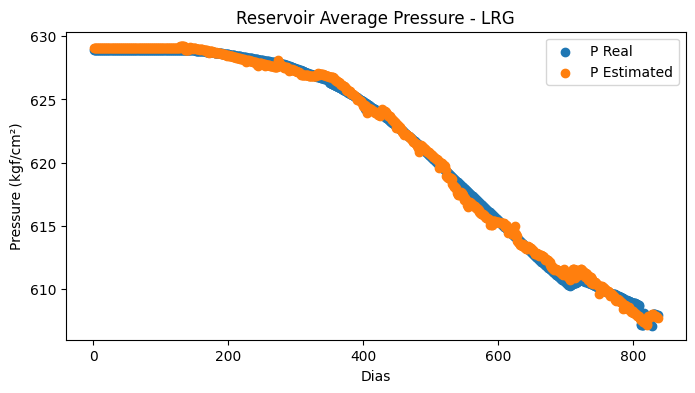

In [18]:
#Verificando LRG:

clf = Pipeline([(models[0])])
        
random_search = RandomizedSearchCV(clf, verbose = True, scoring = 'neg_mean_squared_error', param_distributions = param_grids[0], 
                                       n_iter = 100, n_jobs = -1, cv = rkf, random_state = 0)

random_search.fit(X_train, y_train)

yh_LRG = random_search.predict(X2)

dias = range(1,837)

plt.figure(figsize=(8, 4))
plt.scatter(dias, y, label='P Real')
plt.scatter(dias, yh_LRG, label='P Estimated')

# Personalizar o gráfico
plt.title('Reservoir Average Pressure - LRG')
plt.xlabel('Dias')
plt.ylabel('Pressure (kgf/cm²)')
plt.legend()

# Mostrar o gráfico
plt.show()

Fitting 250 folds for each of 100 candidates, totalling 25000 fits


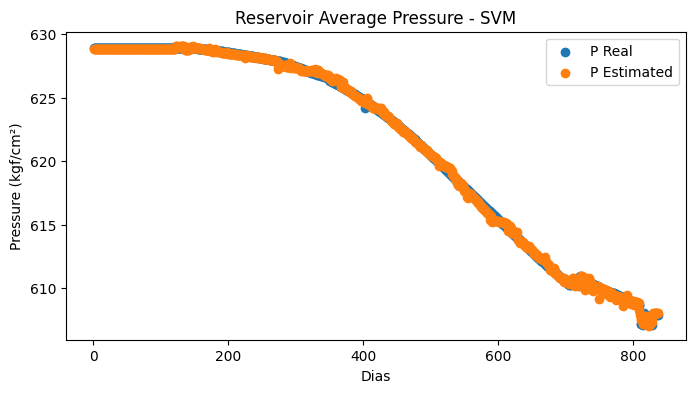

In [19]:
#Verificando SVM:

clf = Pipeline([(models[1])])
        
random_search_2 = RandomizedSearchCV(clf, verbose = True, scoring = 'neg_mean_squared_error', param_distributions = param_grids[1], 
                                       n_iter = 100, n_jobs = -1, cv = rkf, random_state = 0)

random_search_2.fit(X_train, y_train)

yh_SVM = random_search_2.predict(X2)

dias = range(1,837)

plt.figure(figsize=(8, 4))
plt.scatter(dias, y, label='P Real')
plt.scatter(dias, yh_SVM, label='P Estimated')

# Personalizar o gráfico
plt.title('Reservoir Average Pressure - SVM')
plt.xlabel('Dias')
plt.ylabel('Pressure (kgf/cm²)')
plt.legend()

# Mostrar o gráfico
plt.show()

Fitting 250 folds for each of 100 candidates, totalling 25000 fits


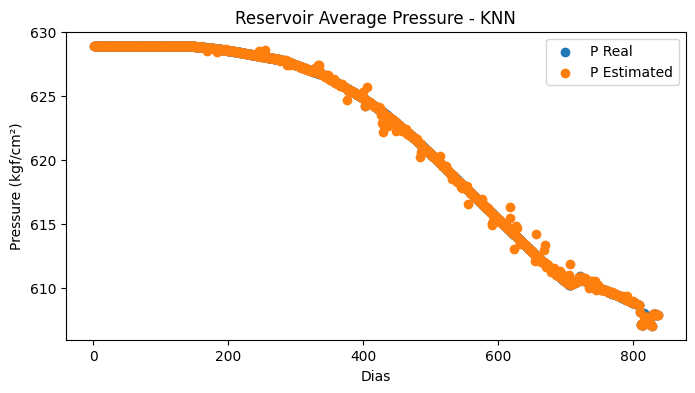

In [20]:
#Verificando KNN:

clf = Pipeline([(models[2])])
        
random_search_3 = RandomizedSearchCV(clf, verbose = True, scoring = 'neg_mean_squared_error', param_distributions = param_grids[2], 
                                       n_iter = 100, n_jobs = -1, cv = rkf, random_state = 0)

random_search_3.fit(X_train, y_train)

yh_KNN = random_search_3.predict(X2)

dias = range(1,837)

plt.figure(figsize=(8, 4))
plt.scatter(dias, y, label='P Real')
plt.scatter(dias, yh_KNN, label='P Estimated')

# Personalizar o gráfico
plt.title('Reservoir Average Pressure - KNN')
plt.xlabel('Dias')
plt.ylabel('Pressure (kgf/cm²)')
plt.legend()

# Mostrar o gráfico
plt.show()

In [21]:
r2_LRG = r2_score(y, yh_LRG)
r2_SVM = r2_score(y, yh_SVM)
r2_KNN = r2_score(y, yh_KNN)

print(r2_LRG)
print(r2_SVM)
print(r2_KNN)

0.9977605303172139
0.9994626674620181
0.9992812579864253
